# Testando em duas dimensões

In [ ]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/1b7d5475863c15f484ac495bd70975cf/raw/16aff7a0aee67e7c100a2a48b676a2d2d142f646/projects.csv"
dados = pd.read_csv(uri)
dados.head()

Para ficar mais didático, trocaremos os valores do **unfinished** para **finished**.

In [98]:
trocar = {
    0 : 1,
    1 : 0
}

dados['finished'] = dados.unfinished.map(trocar)
dados.tail()

,unfinished,expected_hours,price,finished
2152,0,80,7518,1
2153,1,52,1332,0
2154,0,40,473,1
2155,0,75,5324,1
2156,1,37,377,0


Vamos agora *plotar* os dados da tabela para que seja possível visualizarmos os dados
O atributo *hue* faz a coloração do dado de acordo com os status 'finalizados'

<AxesSubplot:xlabel='expected_hours', ylabel='price'>

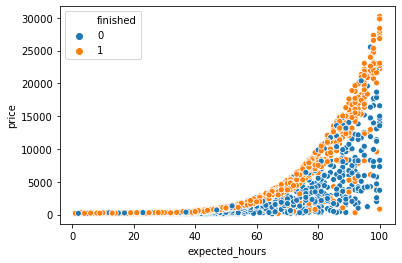

In [99]:
import seaborn as sns

sns.scatterplot(x='expected_hours', y='price', hue='finished', data=dados)


Já feita a análise, agora queremos treinar esse dados. Pra isso vamos separar os dados

In [100]:
x = dados[['expected_hours', 'price']]
y = dados['finished']

In [101]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


SEED = 5

treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, random_state = SEED, test_size = 0.20, stratify=y)

print("Vamos treinar %d elemntos e testaremos %d elementos" % (len(treino_x), len(teste_x)))

modelo = LinearSVC()
modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100

print("A acurácia foi de %.2f%%" % acuracia)

Vamos treinar 1725 elemntos e testaremos 432 elementos
A acurácia foi de 47.69%


c:\users\vitor.henrique\documents\projetos\python\machine-learning-python\introducao-classificacao-sklearn\.venv\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


A acurária do modelo parece baixa. Porém, não temos base de comparação para isso. Portanto, temos que criar um modelo
 base de comparação. Vamos então supor que todos os estão finalizados (finalizado = 1) e vamos ver qual é a porcentagem
  da
 acurário

In [102]:
import numpy as np

previsoes_todos_finalizados = np.ones(432)
acuracia = accuracy_score(teste_y, previsoes_todos_finalizados) * 100
print("A acurácia foi de %.2f%%" % acuracia)


A acurácia foi de 52.55%


Percebemos que o nosso modelo é um pouco melhor do que o modelo base.

## Curva de Decisão

Quando temos dados que podem ser trabalhados no plano cartesiano, nós podemos desenhar o plano cartesiano de modo a
ós mostrar as regiões de cada classe do modelo

Por isso vamos dividir o *canvas* di gráfico para que possa fazer essa divisão das classe de acordo com o nosso
modelo. Dividiremos o plano cartesiano por 100 x 100

In [103]:
x_min = teste_x.expected_hours.min()
x_max = teste_x.expected_hours.max()
y_min = teste_x.price.min()
y_max = teste_x.price.max()


pd.DataFrame([[x_min, x_max],[y_min,y_max]],
             columns=['min','max'],
             index=['x','y'])

,min,max
x,1,100
y,100,30223


Então vamos pegar o mínimo e o máximo de cada eixo e divido me número de bloco por cada eixo

In [104]:
tamanho_bloco = 100

eixo_x = np.arange(x_min, x_max, (x_max - x_min) / tamanho_bloco)
eixo_y = np.arange(y_min, y_max, (y_max - y_min) / tamanho_bloco)

Agora que ja temos o elementos de cada eixo. Nos temos no momento 2 vetores com o seguinte tamanho, respectivamente ,$
 x * 1$ e $ y * 1$.

 Porém, queremos uma matrix de valors de tamanho $ x.y $

 Para isso, vamos usar o *np.meshgrid*. Ele criar transforma o vetor **eixo x** em uma matriz que contem $y$ vezes o
 **eixo x**. E vice-versa. Mas, todos as linhas terão o mesmo valor portanto

```
 eixo_x = [1,2,3,4,....,99,100]
 xx = [
    [1,2,3,4,....,99,100],
    [1,2,3,4,....,99,100],
    ...
    [1,2,3,4,....,99,100]
    ]
```


Assim, o `xx` tem o tamanho que queremos que é $xy$. Mas ainda assim queremos que o valores sejam atualizados de acordo
 com o `eixo y`. Por isso usamos a função `np.c_`


In [105]:
xx, yy = np.meshgrid(eixo_x, eixo_y)
pontos = np.c_[xx.ravel(), yy.ravel()]
pontos

array([[1.000000e+00, 1.000000e+02],
       [1.990000e+00, 1.000000e+02],
       [2.980000e+00, 1.000000e+02],
       ...,
       [9.703000e+01, 2.992177e+04],
       [9.802000e+01, 2.992177e+04],
       [9.901000e+01, 2.992177e+04]])

Já que obtivemos os pontos, devemos então rodar o nosso modelo de apredizagem de máquina e rodar para todo o nosso
plano cartesiano (representado pela variavel pontos)

In [106]:
Z = modelo.predict(pontos)
Z = Z.reshape(xx.shape)
Z

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int64)

Tendo nosso modelo. Vamos *plota-lo* no plano cartesiano. Feito isso, podemos ver no canvas a curva que define as
divisões das classes. No caso, o elementos que ficam em baixo da linha, tem mais chance de serem terminados, enquanto
 os que estão acima não.

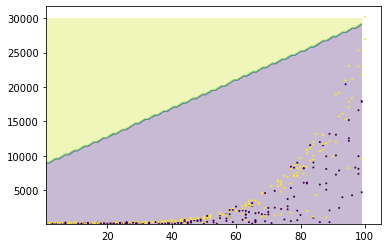

In [107]:
import matplotlib.pyplot as plt

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(teste_x.expected_hours, teste_x.price,
            c=teste_y, s=1)
